# Desk calculator project:

The task is to build a quantum circuit that performs the difference between the binary reprentations
of two positive integers. The circuit can be defined as a variation of the quantum adder explained
in class and using the Quantum Fourier Transform.
The circuit must be implemented in Qiskit and demonstrated on a one or two instances.
The project can be extended with the implementation of a complete desk calculator

## Toffoli approach

In [15]:
from qiskit import *

In [16]:
input1 = int(input("Enter a positive integer between 0 and 15: "))
input2 = int(input("Enter a positive integer between 0 and 15: "))

while (input1 < 0 or input1 > 15) or (input2 < 0 or input2 > 15):
    input1 = int(input("Enter a positive integer between 0 and 15: "))
    input2 = int(input("Enter a positive integer between 0 and 15: "))

first = '{0:{fill}3b}'.format(input1, fill='0')
second = '{0:{fill}3b}'.format(input2, fill='0')
print(first, second)


Enter a positive integer between 0 and 63: 6


KeyboardInterrupt: Interrupted by user

In [ ]:
# We check which number is the longest and we take that length 'n' to declare two quantumRegisters that contain 'n' qubits.
l = len(first)
l2 = len(second)
if l > l2:
     n = l
else:
     n = l2
        
# Initializing the registers; three quantum registers with n bits each
# 1 more with n+1 bits, which will hold the sum of the two #numbers
# The last q-register has three bits to temporally store information
# The classical register has n+1 bits, which is used to make the sum readable
a = QuantumRegister(n) #First number
b = QuantumRegister(n) #Second number
c = QuantumRegister(n) #Carry bits
supp = QuantumRegister(3) #support bit
ris = QuantumRegister(n+1) #Result bits
cl = ClassicalRegister(n+1) #Classical output

# Combining all of them into one quantum circuit
qc = QuantumCircuit(a, b, c, supp, ris, cl)
qc.draw('mpl')

In [ ]:
# Setting up the registers using the values inputted
# since the qubits initially always start from 0, we use not gate to set 1 our qubits where in the binary number
# inserted there is a 1
for i in range(l):
    if first[i] == "1":
        qc.x(a[l - (i+1)]) #Flip the qubit from 0 to 1
for i in range(l2):
    if second[i] == "1":
        qc.x(b[l2 - (i+1)]) #Flip the qubit from 0 to 1
qc.draw('mpl')

In [ ]:
# Ripple Carry Adder
    
# sum = (a xor b) xor cin
# cout = (a and b) OR ((a xor b) and cin)
# Note: instead of using an OR gate we can use a XOR one. 
# In fact the two AND, which are the inputs for the OR, can never both be equal to one, 
# so the last case in the truth table (A=1, B=1) of XOR and OR does not apply, making XOR and OR equal

for i in range(n-1):
    #SUM
    #sum = (a xor b) xor cin
    # use cnots to write the XOR of the inputs on qubit 2
    qc.cx(a[i], ris[i])
    qc.cx(b[i], ris[i])
    
    qc.cx(c[i], ris[i])

    #CARRY
    #cout = (a and b) XOR ((a xor b) and cin)
    #cout = i+1
    #cin = i
    # use ccx to write the AND of the inputs on qubit 3
    qc.ccx(a[i],b[i],supp[2])
    
    qc.cx(a[i], supp[0])
    qc.cx(b[i], supp[0])
    
    qc.ccx(supp[0], c[i], supp[1])
    
    qc.cx(supp[1], c[i+1])
    qc.cx(supp[2], c[i+1])  
    
    #reset to 0 supp
    qc.reset([9]*5)
    qc.reset([10]*5)
    qc.reset([11]*5)

#SUM
#sum = (a xor b) xor cin
qc.cx(a[n-1], ris[n-1])
qc.cx(b[n-1], ris[n-1])

qc.cx(c[n-1], ris[n-1])

#CARRY
#cout = (a and b) XOR ((a xor b) and cin)
#cout = i+1
#cin = i
# use ccx to write the AND of the inputs on qubit 3
qc.ccx(a[n-1],b[n-1],supp[2])

qc.cx(a[n-1], supp[0])
qc.cx(b[n-1], supp[0])

qc.ccx(supp[0], c[n-1], supp[1])

#note: instead of saving the last cout in the c qubit, we store it in the last digit of the result (hence the longer ris + 1)
qc.cx(supp[1], ris[n])
qc.cx(supp[2], ris[n])  

#reset to 0 supp
qc.reset([9]*5)
qc.reset([10]*5)
qc.reset([11]*5)

    
for i in range(n+1):
    qc.measure(ris[i], cl[i])
    
qc.draw('mpl')

In [ ]:
#Version using the local simulator

#Set chosen backend and execute job
num_shots = 100 #Setting the number of times to repeat measurement
job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
#Get results of program
job_stats = job.result().get_counts()

In [8]:
print(job_stats) 

{'01111': 100}


In [ ]:
#Version using the remote simulator

IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_qasm_simulator')
counts = execute(qc, backend, shots=100).result().get_counts()
print(counts)

# Addition with QFT

In [18]:
import math
import operator
from qiskit import *

'''
qc: input quantum circuit
reg: input register to execute QFT
n: n-th qbit to apply hadamard and phase rotation
pie: pie number
'''
def createInputState(qc, reg, n, pie):
    # Computes the quantum Fourier transform of reg, one qubit a time
    # Apply one Hadamard gate to the n-th qubit of the quantum register reg, and 
    # then apply repeated phase rotations with parameters being pi divided by 
    # increasing powers of two
    
    qc.h(reg[n])    
    for i in range(0, n):
        qc.cp(pie/float(2**(i+1)), reg[n-(i+1)], reg[n])    

'''
qc: input quantum circuit
reg_a: first input register to execute QFT
reg_b: second input register to execute QFT
n: n-th qbit to apply hadamard and phase rotation
pie: pie number
'''
def evolveQFTState(qc, reg_a, reg_b, n, pie):
    # Evolves the state |F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))> using the quantum 
    # Fourier transform conditioned on the qubits of the reg_b.
    # Apply repeated phase rotations with parameters being pi divided by 
    # increasing powers of two.
    
    for i in range(n+1):
        qc.cp(pie/float(2**(i)), reg_b[n-i], reg_a[n])

'''
qc: input quantum circuit
reg: input register to execute QFT
n: n-th qbit to apply hadamard and phase rotation
pie: pie number
'''        
def inverseQFT(qc, reg, n, pie):
    # Performs the inverse quantum Fourier transform on a register reg.
    # Apply repeated phase rotations with parameters being pi divided by 
    # decreasing powers of two, and then apply a Hadamard gate to the nth qubit
    # of the register reg.
    
    for i in range(n):
        qc.cp(-1*pie/float(2**(n-i)), reg[i], reg[n])
    qc.h(reg[n])
    
'''
first: first number to add
second: second number to add
n: lenght of both number (normalized to the same binary lenght)
a: first input register, representing the first number to add
a: second input register, representing the second number to add
cl: classical register, to read the result
qc: input quantum circuit
'''
def add(first, second, n, a, b, cl, qc):
    # Flip the corresponding qubit in register a if a bit in the string first is a 1
    for i in range(n):
        if first[i] == "1":
            qc.x(a[n-(i+1)])
    # Flip the corresponding qubit in register b if a bit in the string second is a 1
    for i in range(n):
        if second[i] == "1":
            qc.x(b[n-(i+1)])
            
    # Compute the Fourier transform of register a
    for i in range(n+1):
        createInputState(qc, a, n-i, pie)
        
    # Add the two numbers by evolving the Fourier transform F(ψ(reg_a))>
    # to |F(ψ(reg_a+reg_b))>
    for i in range(n+1):
        evolveQFTState(qc, a, b, n-i, pie) 
        
    # Compute the inverse Fourier transform of register a
    for i in range(n+1):
        inverseQFT(qc, a, i, pie)
        
    # Measure qubits
    for i in range(n+1):
        qc.measure(a[i], cl[i])
    
    # Execute using the local simulator

    # Set chosen backend and execute job
    num_shots = 100 #Setting the number of times to repeat measurement
    job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
    # Get results of program
    job_stats = job.result().get_counts()
    print(job_stats)
    
    # Execute using the remote simulator
    '''
    IBMQ.load_account()
    provider = IBMQ.get_provider()
    backend = provider.get_backend('ibmq_qasm_simulator')
    counts = execute(qc, backend, shots=100).result().get_counts()
    print(counts)
    #Select result with maximum probabilities
    output = max(counts.items(), key=operator.itemgetter(1))[0]
    print(output)
    '''

Enter a positive integer between 0 and 2047: 2
Enter a positive integer between 0 and 2047: 3
010 011
{'0101': 100}


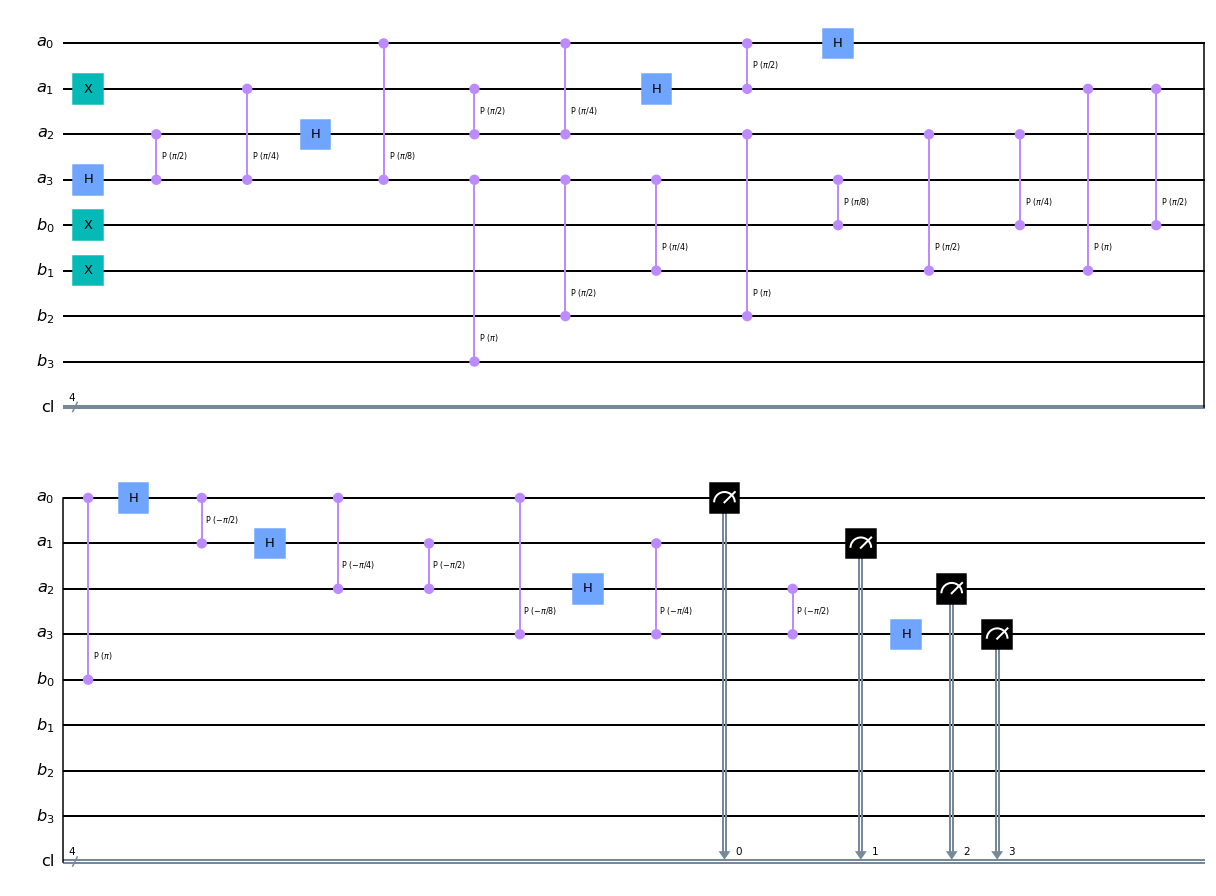

In [25]:
input1 = int(input("Enter a positive integer between 0 and 2047: "))
input2 = int(input("Enter a positive integer between 0 and 2047: "))

while (input1 < 0 or input1 > 2047) or (input2 < 0 or input2 > 2047):
    input1 = int(input("Enter a positive integer between 0 and 2047: "))
    input2 = int(input("Enter a positive integer between 0 and 2047: "))

first = '{0:{fill}3b}'.format(input1, fill='0')
second = '{0:{fill}3b}'.format(input2, fill='0')

l1 = len(first)
l2 = len(second)

# Making sure that 'first' and 'second' are of the same length 
# by padding the smaller string with zeros
if l2>l1:
    first,second = second, first
    l2, l1 = l1, l2
second = ("0")*(l1-l2) + second
n = l1

print(first, second)

pie = math.pi
a = QuantumRegister(n+1, "a") 
b = QuantumRegister(n+1, "b")     
cl = ClassicalRegister(n+1, "cl") 
qc = QuantumCircuit(a, b, cl, name="qc")

add(first, second, l1, a, b, cl, qc)

qc.draw('mpl')
